In [1]:
# import tensorflow as tf

# print(tf.__version__)

In [2]:
# import os
# os.environ.get("tf_upgrade_v2")

In [3]:
# !tf_upgrade_v2 \
#   --infile /home/zcxia/TradeMaster/data_synthesis/TimeGAN/timegan.py \
#   --outfile /home/zcxia/TradeMaster/data_synthesis/TimeGAN/timegan_v2.py \
#   --reportfile report.txt

In [4]:
# import tensorflow as tf

# print(tf.__version__)

In [5]:
# import os
# os.environ.get("tf_upgrade_v2")

# TimeGAN Tutorial

## Time-series Generative Adversarial Networks

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

- Last updated Date: April 24th 2020

- Code author: Jinsung Yoon (jsyoon0823@gmail.com)

This notebook describes the user-guide of a time-series synthetic data generation application using timeGAN framework. We use Stock, Energy, and Sine dataset as examples.

### Prerequisite
Clone https://github.com/jsyoon0823/timeGAN.git to the current directory.

## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [6]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization
import pandas as pd
from tqdm import tqdm

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [7]:
data=pd.read_csv("/home/zcxia/TradeMaster/data/data/dj30/dj30_labeled_3_24.csv").reset_index()

In [8]:
display(data)

index  Unnamed: 0        date        open        high         low  \
0          0           0  2012-01-03   14.621429   14.732143   14.607143   
1          1           1  2012-01-04   14.642857   14.810000   14.617143   
2          2           2  2012-01-05   14.819643   14.948214   14.738214   
3          3           3  2012-01-06   14.991786   15.098214   14.972143   
4          4           4  2012-01-09   15.196429   15.276786   15.048214   
...      ...         ...         ...         ...         ...         ...   
72988  72988       72988  2021-12-27  139.600006  140.869995  139.570007   
72989  72989       72989  2021-12-28  140.600006  142.970001  140.600006   
72990  72990       72990  2021-12-29  142.660004  143.529999  142.320007   
72991  72991       72991  2021-12-30  143.259995  143.699997  142.479996   
72992  72992       72992  2021-12-31  143.199997  145.039993  142.919998   

            close       adjcp   tic     zopen  ...     zd_10     zd_15  \
0       14.686786   12.575916  AAPL -0.004450  ... -0.011415  0.002751   
1       14.765714   12.643501  AAPL -0.008320  ... -0.011415  0.002751   
2       14.929643   12.783867  AAPL -0.007368  ... -0.011415  0.002751   
3       15.085714   12.917509  AAPL -0.006226  ... -0.011415  0.002751   
4       15.061786   12.897021  AAPL  0.008939  ... -0.011415  0.002751   
...           ...         ...   ...       ...  ...       ...       ...   
72988  140.759995  140.217682   WMT -0.008241  ...  0.005428 -0.001702   
72989  142.779999  142.229904   WMT -0.015268  ... -0.009350 -0.013800   
72990  142.710007  142.160172   WMT -0.000350  ... -0.010427 -0.011113   
72991  143.169998  142.618393   WMT  0.000629  ... -0.015422 -0.011231   
72992  144.690002  144.132538   WMT -0.010298  ... -0.024832 -0.018767   

          zd_20     zd_25     zd_30  pct_return  adjcp_filtered  \
0     -0.061124 -0.072128 -0.126481    0.000000       12.575621   
1     -0.061124 -0.072128 -0.126481    0.005374       12.696937   
2     -0.061124 -0.072128 -0.126481    0.011102       12.800068   
3     -0.061124 -0.072128 -0.126481    0.010454       12.870550   
4     -0.061124 -0.072128 -0.126481   -0.001586       12.903865   
...         ...       ...       ...         ...             ...   
72988 -0.005965  0.000262  0.004064    0.009105      140.434421   
72989 -0.019776 -0.013620 -0.011165    0.014351      141.491412   
72990 -0.018369 -0.013554 -0.011524   -0.000490      142.436433   
72991 -0.019225 -0.017298 -0.014566    0.003223      143.289840   
72992 -0.026154 -0.027970 -0.024153    0.010617      144.111956   

       pct_return_filtered  label  stock_type  
0                -0.001100      2           0  
1                 0.000104      2           0  
2                 0.001207      2           0  
3                 0.002026      2           0  
4                 0.002478      2           0  
...                    ...    ...         ...  
72988             0.001502      1           0  
72989             0.003784      1           0  
72990             0.006163      1           0  
72991             0.008511      1           0  
72992             0.010755      1           0  

[72993 rows x 25 columns]

# preprocess data by stock group and regime

Seperate data into groups by (stock_type,regime_type)

In [9]:
tics=data['tic'].unique()

In [10]:
stock_group_num=len(data['stock_type'].unique())
regime_num=len(data['label'].unique())

In [11]:
data_by_regime={}

In [12]:
for i in range(stock_group_num):
    for j in range(regime_num):
        data_seg=data.loc[(data['stock_type']==i) & (data['label']==j),['index','open','high','low','close','adjcp','pct_return','adjcp_filtered','pct_return_filtered']]
#         data_dict[(i,j)]=data_seg
        data_seg.to_csv('data_seg_'+str(i)+'_'+str(j)+'.csv')

In [13]:
for tic in tics:
    for j in range(regime_num):
        data_seg=data.loc[(data['tic']==tic) & (data['label']==j),['index','open','high','low','close','adjcp','pct_return','adjcp_filtered','pct_return_filtered']]
#         data_dict[(i,j)]=data_seg
        data_seg.to_csv('data_seg_'+tic+'_'+str(j)+'.csv')

In [14]:
def get_intervals(data):
    index=data['index']
    last_value=index[0]-1
    last_index=0
    intervals=[]
    for i in range(data.shape[0]):
        if last_value!=index[i]-1:
            intervals.append([last_index,i])
            last_value=index[i]
            last_index=i
        last_value=index[i]
    return intervals

In [15]:
def interpolation(data):
    max_len=24
    l=len(data)
    to_fill=max_len-l
    if to_fill!=0:
        interval=max_len//to_fill
        for j in range(to_fill):
            idx=(interval+1)*j+interval
            data.insert(min(idx,len(data)-1),float('nan'))
    data=pd.Series(data).interpolate(method='polynomial', order=2)
    return data

In [16]:
def minmax_normlization(data):
    normalized_data=(data-data.min())/(data.max()-data.min())
    return normalized_data

In [17]:
def get_data_of_same_length(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        for i in range(0, len(data_seg) - seq_len):
            _x = data[i:i + seq_len]
            temp_data.append(_x)
    return temp_data

In [18]:
test_data=pd.read_csv('data_seg_0_0.csv')

In [19]:
process_data=get_data_of_same_length(test_data,24)

In [20]:
display(process_data)

[    Unnamed: 0  index       open       high        low      close      adjcp  \
 0           66     66  22.361786  22.851429  22.332144  22.722500  19.456690   
 1           67     67  22.854643  23.000000  22.357143  22.444286  19.218456   
 2           68     68  22.721430  22.745358  22.262142  22.364286  19.149956   
 3           69     69  22.321428  22.547501  22.160713  22.241785  19.045067   
 4           70     70  22.289642  22.310715  21.553928  21.615356  18.508671   
 5           71     71  21.787857  21.795713  20.651787  20.718929  17.741079   
 6           72     72  20.676430  21.785713  20.425358  21.775000  18.645365   
 7           73     73  21.918571  22.151787  21.525356  21.726429  18.603785   
 8           74     74  21.436428  21.597500  20.875713  20.980000  17.964636   
 9           75     75  21.120714  21.236429  20.372143  20.463572  17.522429   
 10          76     76  20.378929  20.595358  19.879286  20.417856  17.483282   
 11          77     77  20.0

# Leverage Effect

In [21]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].pct_return.to_numpy()
        std=data_seg.std()
        std_list.append(std)
    return std_list

single stock

In [22]:
for tic in tics:
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+tic+'_'+str(j)+'.csv')
        print('stock',tic,'regime',j)
        std_list=get_std_list(data)
        display(pd.DataFrame(std_list).describe()) 

stock AAPL regime 0


0
count  9.000000
mean   0.020886
std    0.005832
min    0.014411
25%    0.016206
50%    0.019266
75%    0.024828
max    0.029776

stock AAPL regime 1


0
count  17.000000
mean    0.017245
std     0.010832
min     0.007756
25%     0.010101
50%     0.016661
75%     0.017717
max     0.053692

stock AAPL regime 2


0
count  20.000000
mean    0.014343
std     0.002985
min     0.009344
25%     0.011940
50%     0.014121
75%     0.016689
max     0.020478

stock AMGN regime 0


0
count  10.000000
mean    0.018457
std     0.007132
min     0.008482
25%     0.014735
50%     0.018346
75%     0.020121
max     0.035298

stock AMGN regime 1


0
count  17.000000
mean    0.013193
std     0.003837
min     0.007035
25%     0.010569
50%     0.012758
75%     0.016803
max     0.019731

stock AMGN regime 2


0
count  18.000000
mean    0.014601
std     0.005595
min     0.008663
25%     0.011883
50%     0.012885
75%     0.014921
max     0.033364

stock AXP regime 0


0
count  7.000000
mean   0.024677
std    0.017537
min    0.013524
25%    0.014503
50%    0.017983
75%    0.024623
max    0.062980

stock AXP regime 1


0
count  14.000000
mean    0.013264
std     0.003123
min     0.008602
25%     0.011367
50%     0.013067
75%     0.014057
max     0.021121

stock AXP regime 2


0
count  13.000000
mean    0.017798
std     0.014756
min     0.006297
25%     0.010527
50%     0.011283
75%     0.015654
max     0.054664

stock BA regime 0


0
count  12.000000
mean    0.027113
std     0.019939
min     0.017164
25%     0.017862
50%     0.018759
75%     0.026153
max     0.086811

stock BA regime 1


0
count  17.000000
mean    0.014748
std     0.005271
min     0.008151
25%     0.010665
50%     0.013286
75%     0.016750
max     0.028495

stock BA regime 2


0
count  15.000000
mean    0.020900
std     0.014356
min     0.010215
25%     0.012652
50%     0.015414
75%     0.019937
max     0.063674

stock CAT regime 0


0
count  12.000000
mean    0.019207
std     0.006595
min     0.010924
25%     0.016305
50%     0.017977
75%     0.019243
max     0.038002

stock CAT regime 1


0
count  17.000000
mean    0.015225
std     0.005155
min     0.009853
25%     0.012382
50%     0.013752
75%     0.016417
max     0.031207

stock CAT regime 2


0
count  17.000000
mean    0.015252
std     0.004367
min     0.008396
25%     0.011758
50%     0.015776
75%     0.017079
max     0.024293

stock CRM regime 0


0
count  12.000000
mean    0.023008
std     0.008020
min     0.012316
25%     0.017586
50%     0.020573
75%     0.026596
max     0.041117

stock CRM regime 1


0
count  16.000000
mean    0.017630
std     0.006907
min     0.008040
25%     0.014099
50%     0.015094
75%     0.021482
max     0.036083

stock CRM regime 2


0
count  20.000000
mean    0.017953
std     0.006665
min     0.008195
25%     0.012943
50%     0.018631
75%     0.020530
max     0.036507

stock CSCO regime 0


0
count  9.000000
mean   0.020394
std    0.008696
min    0.012350
25%    0.015687
50%    0.018472
75%    0.020613
max    0.041375

stock CSCO regime 1


0
count  20.000000
mean    0.012910
std     0.003702
min     0.006808
25%     0.009928
50%     0.013023
75%     0.016519
max     0.017905

stock CSCO regime 2


0
count  19.000000
mean    0.014008
std     0.005992
min     0.007371
25%     0.009631
50%     0.012730
75%     0.015477
max     0.032123

stock CVX regime 0


0
count  9.000000
mean   0.018519
std    0.011985
min    0.008873
25%    0.011606
50%    0.014777
75%    0.018470
max    0.048028

stock CVX regime 1


0
count  19.000000
mean    0.012495
std     0.004883
min     0.007547
25%     0.008929
50%     0.011013
75%     0.015136
max     0.026123

stock CVX regime 2


0
count  14.000000
mean    0.016988
std     0.014404
min     0.006644
25%     0.009190
50%     0.011976
75%     0.018730
max     0.061690

stock DIS regime 0


0
count  6.000000
mean   0.019686
std    0.010352
min    0.010053
25%    0.013921
50%    0.015656
75%    0.022716
max    0.038341

stock DIS regime 1


0
count  15.000000
mean    0.011357
std     0.003864
min     0.007272
25%     0.008967
50%     0.010982
75%     0.012398
max     0.023682

stock DIS regime 2


0
count  17.000000
mean    0.014886
std     0.007895
min     0.007817
25%     0.009583
50%     0.011024
75%     0.018238
max     0.038246

stock GS regime 0


0
count  8.000000
mean   0.015862
std    0.003243
min    0.011987
25%    0.012963
50%    0.016125
75%    0.017656
max    0.020861

stock GS regime 1


0
count  18.000000
mean    0.014124
std     0.003141
min     0.009119
25%     0.012483
50%     0.013274
75%     0.016205
max     0.022705

stock GS regime 2


0
count  14.000000
mean    0.016079
std     0.007873
min     0.007386
25%     0.011814
50%     0.013994
75%     0.018577
max     0.039248

stock HD regime 0


0
count  6.000000
mean   0.013588
std    0.002935
min    0.010412
25%    0.011132
50%    0.013522
75%    0.015224
max    0.017947

stock HD regime 1


0
count  14.000000
mean    0.011409
std     0.003258
min     0.005691
25%     0.009383
50%     0.011984
75%     0.012549
max     0.018313

stock HD regime 2


0
count  17.000000
mean    0.011311
std     0.004157
min     0.005933
25%     0.008849
50%     0.010106
75%     0.012335
max     0.025105

stock HON regime 0


0
count  6.000000
mean   0.018851
std    0.009982
min    0.011725
25%    0.014647
50%    0.015071
75%    0.017188
max    0.038841

stock HON regime 1


0
count  15.000000
mean    0.011722
std     0.003849
min     0.006694
25%     0.009353
50%     0.010751
75%     0.013562
max     0.022448

stock HON regime 2


0
count  14.000000
mean    0.014191
std     0.007963
min     0.007350
25%     0.009491
50%     0.012002
75%     0.015277
max     0.038706

stock IBM regime 0


0
count  10.000000
mean    0.018048
std     0.010009
min     0.008656
25%     0.013978
50%     0.016568
75%     0.017594
max     0.044808

stock IBM regime 1


0
count  19.000000
mean    0.011759
std     0.003229
min     0.008072
25%     0.009021
50%     0.010737
75%     0.013965
max     0.018619

stock IBM regime 2


0
count  14.000000
mean    0.012814
std     0.006264
min     0.006335
25%     0.008650
50%     0.011873
75%     0.014200
max     0.031138

stock INTC regime 0


0
count  9.000000
mean   0.019607
std    0.005959
min    0.011808
25%    0.016794
50%    0.017270
75%    0.023452
max    0.030637

stock INTC regime 1


0
count  19.000000
mean    0.017721
std     0.011860
min     0.008906
25%     0.011959
50%     0.013236
75%     0.019605
max     0.061900

stock INTC regime 2


0
count  20.000000
mean    0.016157
std     0.004900
min     0.008471
25%     0.013351
50%     0.014784
75%     0.018353
max     0.027779

stock JNJ regime 0


0
count  3.000000
mean   0.025103
std    0.014495
min    0.011309
25%    0.017550
50%    0.023791
75%    0.032001
max    0.040210

stock JNJ regime 1


0
count  13.000000
mean    0.009092
std     0.002080
min     0.006035
25%     0.007894
50%     0.008919
75%     0.010071
max     0.013525

stock JNJ regime 2


0
count  9.000000
mean   0.009336
std    0.006063
min    0.005361
25%    0.005893
50%    0.007991
75%    0.008974
max    0.024854

stock JPM regime 0


0
count  7.000000
mean   0.015824
std    0.005064
min    0.008073
25%    0.012170
50%    0.017246
75%    0.019783
max    0.021541

stock JPM regime 1


0
count  23.000000
mean    0.013212
std     0.003814
min     0.007758
25%     0.011203
50%     0.012298
75%     0.013779
max     0.026322

stock JPM regime 2


0
count  21.000000
mean    0.013212
std     0.007471
min     0.006247
25%     0.009320
50%     0.012661
75%     0.013716
max     0.041648

stock KO regime 0


0
count  2.000000
mean   0.023115
std    0.024944
min    0.005477
25%    0.014296
50%    0.023115
75%    0.031934
max    0.040753

stock KO regime 1


0
count  8.000000
mean   0.011583
std    0.005955
min    0.006055
25%    0.008776
50%    0.009750
75%    0.011760
max    0.025162

stock KO regime 2


0
count  7.000000
mean   0.009796
std    0.003357
min    0.006646
25%    0.007227
50%    0.007996
75%    0.012066
max    0.015346

stock MCD regime 0


0
count  6.000000
mean   0.011296
std    0.003805
min    0.005854
25%    0.009939
50%    0.010927
75%    0.012549
max    0.017369

stock MCD regime 1


0
count  14.000000
mean    0.009387
std     0.002223
min     0.005603
25%     0.008299
50%     0.008799
75%     0.010520
max     0.014648

stock MCD regime 2


0
count  10.000000
mean    0.012681
std     0.008789
min     0.007032
25%     0.007582
50%     0.007956
75%     0.015536
max     0.035294

stock MMM regime 0


0
count  6.000000
mean   0.017538
std    0.004286
min    0.011715
25%    0.015600
50%    0.016772
75%    0.019685
max    0.024104

stock MMM regime 1


0
count  19.000000
mean    0.012554
std     0.009420
min     0.004704
25%     0.008195
50%     0.010561
75%     0.012778
max     0.049003

stock MMM regime 2


0
count  17.000000
mean    0.011215
std     0.004425
min     0.005575
25%     0.009531
50%     0.010696
75%     0.013040
max     0.023537

stock MRK regime 0


0
count  3.000000
mean   0.016784
std    0.004087
min    0.014200
25%    0.014428
50%    0.014655
75%    0.018076
max    0.021496

stock MRK regime 1


0
count  14.000000
mean    0.011313
std     0.003039
min     0.006341
25%     0.009878
50%     0.010909
75%     0.013411
max     0.016603

stock MRK regime 2


0
count  11.000000
mean    0.011679
std     0.003433
min     0.008438
25%     0.009684
50%     0.011112
75%     0.012252
max     0.020894

stock MSFT regime 0


0
count  6.000000
mean   0.025549
std    0.017804
min    0.010869
25%    0.015959
50%    0.021984
75%    0.023599
max    0.060369

stock MSFT regime 1


0
count  19.000000
mean    0.013887
std     0.003825
min     0.008238
25%     0.011369
50%     0.013130
75%     0.015203
max     0.021975

stock MSFT regime 2


0
count  15.000000
mean    0.013852
std     0.004734
min     0.007278
25%     0.011330
50%     0.012294
75%     0.014921
max     0.024934

stock NKE regime 0


0
count  9.000000
mean   0.014581
std    0.002907
min    0.011431
25%    0.012084
50%    0.014465
75%    0.015371
max    0.020282

stock NKE regime 1


0
count  20.000000
mean    0.014166
std     0.004296
min     0.008302
25%     0.011321
50%     0.012934
75%     0.017029
max     0.026094

stock NKE regime 2


0
count  18.000000
mean    0.016116
std     0.007128
min     0.007548
25%     0.012258
50%     0.013901
75%     0.017830
max     0.035638

stock PG regime 0


0
count  3.000000
mean   0.012125
std    0.001439
min    0.010929
25%    0.011327
50%    0.011725
75%    0.012723
max    0.013722

stock PG regime 1


0
count  13.000000
mean    0.010339
std     0.004781
min     0.005115
25%     0.008374
50%     0.009052
75%     0.009915
max     0.024338

stock PG regime 2


0
count  10.000000
mean    0.010131
std     0.003470
min     0.005038
25%     0.009115
50%     0.009633
75%     0.010328
max     0.018585

stock TRV regime 0


0
count  3.000000
mean   0.014911
std    0.002350
min    0.013524
25%    0.013555
50%    0.013586
75%    0.015605
max    0.017625

stock TRV regime 1


0
count  15.000000
mean    0.012086
std     0.006394
min     0.006138
25%     0.009611
50%     0.010185
75%     0.012594
max     0.033192

stock TRV regime 2


0
count  12.000000
mean    0.012519
std     0.006222
min     0.005832
25%     0.009488
50%     0.010987
75%     0.012483
max     0.026897

stock UNH regime 0


0
count  6.000000
mean   0.024183
std    0.019191
min    0.012270
25%    0.014071
50%    0.018859
75%    0.019607
max    0.062775

stock UNH regime 1


0
count  17.000000
mean    0.012867
std     0.003328
min     0.007100
25%     0.010705
50%     0.012346
75%     0.014815
max     0.020521

stock UNH regime 2


0
count  17.000000
mean    0.014800
std     0.008761
min     0.007611
25%     0.011917
50%     0.012493
75%     0.014221
max     0.045789

stock V regime 0


0
count  4.000000
mean   0.022324
std    0.013280
min    0.013264
25%    0.014120
50%    0.017131
75%    0.025335
max    0.041771

stock V regime 1


0
count  14.000000
mean    0.013458
std     0.003722
min     0.009598
25%     0.010751
50%     0.012039
75%     0.015251
max     0.023545

stock V regime 2


0
count  14.000000
mean    0.014268
std     0.007136
min     0.008029
25%     0.010477
50%     0.013195
75%     0.014505
max     0.036526

stock VZ regime 0


0
count  4.000000
mean   0.010043
std    0.001265
min    0.008178
25%    0.009893
50%    0.010501
75%    0.010651
max    0.010993

stock VZ regime 1


0
count  13.000000
mean    0.009880
std     0.002028
min     0.007410
25%     0.008679
50%     0.009388
75%     0.010611
max     0.013589

stock VZ regime 2


0
count  12.000000
mean    0.010440
std     0.002789
min     0.007630
25%     0.008132
50%     0.009550
75%     0.012455
max     0.015572

stock WBA regime 0


0
count  9.000000
mean   0.022262
std    0.006597
min    0.014130
25%    0.018390
50%    0.020482
75%    0.022977
max    0.035872

stock WBA regime 1


0
count  18.000000
mean    0.014984
std     0.006472
min     0.007156
25%     0.011358
50%     0.013401
75%     0.017917
max     0.036767

stock WBA regime 2


0
count  14.000000
mean    0.016176
std     0.005131
min     0.010139
25%     0.013413
50%     0.014585
75%     0.018646
max     0.029334

stock WMT regime 0


0
count  4.000000
mean   0.016112
std    0.006253
min    0.009454
25%    0.012207
50%    0.015550
75%    0.019456
max    0.023895

stock WMT regime 1


0
count  14.000000
mean    0.010104
std     0.001750
min     0.006695
25%     0.009303
50%     0.010270
75%     0.011120
max     0.013059

stock WMT regime 2


0
count  11.000000
mean    0.014393
std     0.009599
min     0.007177
25%     0.009215
50%     0.012513
75%     0.014283
max     0.041882

by stock group

In [23]:
for i in range(stock_group_num):
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv')
        print('stock',i,'regime',j)
        std_list=get_std_list(data)
        display(pd.DataFrame(std_list).describe()) 

stock 0 regime 0


0
count  69.000000
mean    0.020105
std     0.011980
min     0.006847
25%     0.013403
50%     0.016698
75%     0.023791
max     0.067049

stock 0 regime 1


0
count  171.000000
mean     0.012485
std      0.005480
min      0.005115
25%      0.009293
50%      0.011299
75%      0.013559
max      0.053692

stock 0 regime 2


0
count  154.000000
mean     0.014259
std      0.008526
min      0.005038
25%      0.009588
50%      0.012082
75%      0.015621
max      0.061690

stock 1 regime 0


0
count  29.000000
mean    0.021239
std     0.015733
min     0.000575
25%     0.012693
50%     0.017133
75%     0.020818
max     0.062775

stock 1 regime 1


0
count  71.000000
mean    0.013268
std     0.003449
min     0.005691
25%     0.011043
50%     0.012773
75%     0.015203
max     0.022705

stock 1 regime 2


0
count  66.000000
mean    0.013889
std     0.006593
min     0.005933
25%     0.010920
50%     0.012315
75%     0.014381
max     0.045789

stock 2 regime 0


0
count  41.000000
mean    0.018817
std     0.008533
min     0.000693
25%     0.013287
50%     0.018390
75%     0.022643
max     0.041375

stock 2 regime 1


0
count  97.000000
mean    0.013470
std     0.006964
min     0.006055
25%     0.009790
50%     0.012163
75%     0.015842
max     0.061900

stock 2 regime 2


0
count  88.000000
mean    0.013562
std     0.005088
min     0.006646
25%     0.010072
50%     0.012872
75%     0.015347
max     0.032123

stock 3 regime 0


0
count  62.000000
mean    0.019403
std     0.008821
min     0.005854
25%     0.014461
50%     0.017516
75%     0.020580
max     0.051852

stock 3 regime 1


0
count  118.000000
mean     0.013290
std      0.005910
min      0.004704
25%      0.009846
50%      0.011998
75%      0.015015
max      0.049003

stock 3 regime 2


0
count  115.000000
mean     0.014257
std      0.006511
min      0.005569
25%      0.009927
50%      0.012684
75%      0.016127
max      0.038706

stock 4 regime 0


0
count  10.000000
mean    0.018048
std     0.010009
min     0.008656
25%     0.013978
50%     0.016568
75%     0.017594
max     0.044808

stock 4 regime 1


0
count  19.000000
mean    0.011759
std     0.003229
min     0.008072
25%     0.009021
50%     0.010737
75%     0.013965
max     0.018619

stock 4 regime 2


0
count  14.000000
mean    0.012814
std     0.006264
min     0.006335
25%     0.008650
50%     0.011873
75%     0.014200
max     0.031138

stock 5 regime 0


0
count  12.000000
mean    0.027113
std     0.019939
min     0.017164
25%     0.017862
50%     0.018759
75%     0.026153
max     0.086811

stock 5 regime 1


0
count  17.000000
mean    0.014748
std     0.005271
min     0.008151
25%     0.010665
50%     0.013286
75%     0.016750
max     0.028495

stock 5 regime 2


0
count  15.000000
mean    0.020900
std     0.014356
min     0.010215
25%     0.012652
50%     0.015414
75%     0.019937
max     0.063674

In [24]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        std=data_seg.adj.std()
        std_list.append(std)
    return std_list

# key takeaway
1. regime 0 has high variance mean and high variance variance
2. regime 1 has low variance mean and low variance variance
3. regime 2 has low variance mean and low/high variance variance

In [25]:
display(len(process_data))

825

In [26]:
for i in tqdm(range(len(process_data))):
    process_data[i]=minmax_normlization(process_data[i])

100%|███████████████████████████████████████████| 825/825 [00:02<00:00, 393.97it/s]


In [90]:
style_data=real_data_loading('data_seg_AAPL_0.csv', 24)

In [84]:
stock_data=real_data_loading('stock', 24)

In [85]:
len(stock_data)

3661

In [91]:
len(style_data)

439

# Pre-train Static learning classification discriminator

In [62]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sktime.classification.kernel_based import RocketClassifier

In [30]:
def get_data_of_same_length_df(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:]
        for i in range(0, len(data_seg) - seq_len):
            _x = data[i:i + seq_len]
            temp_data.append(_x)
    return temp_data

In [59]:
data=pd.read_csv('data_seg_'+"0"+'_'+"0"+'.csv')
display(data.columns)

Index(['Unnamed: 0', 'index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered'],
      dtype='object')

In [63]:
for tic in tics:
    print(tic)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+tic+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

AAPL
1.0
AMGN
1.0
AXP
1.0
BA
1.0
CAT
1.0
CRM
1.0
CSCO
1.0
CVX


KeyboardInterrupt: 

ALL single stock classification have unbelieve 100% acc?

In [92]:
for i in range(stock_group_num):
    print('stock_group',i)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1,use_multivariate='yes')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

stock_group 0
1.0
stock_group 1
1.0
stock_group 2
1.0
stock_group 3
1.0
stock_group 4
1.0
stock_group 5
1.0


Still 1.0?

In [48]:

# X_train, X_test, y_train, y_test = train_test_split(X, y)
# classifier = TimeSeriesForestClassifier()
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# accuracy_score(y_test, y_pred)

# Pre-train Deep learning classification discriminator

### training

In [49]:
from tsai.all import *
my_setup()

os              : Linux-5.8.0-49-generic-x86_64-with-debian-bullseye-sid
python          : 3.7.15
tsai            : 0.3.5
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.1+cu117
device          : 4 gpus (['GeForce RTX 3090', 'GeForce RTX 3090', 'GeForce RTX 3090', 'GeForce RTX 3090'])
cpu cores       : 40
threads per cpu : 2
RAM             : 376.58 GB
GPU memory      : [23.7, 23.7, 23.7, 23.7] GB


stock_group 0


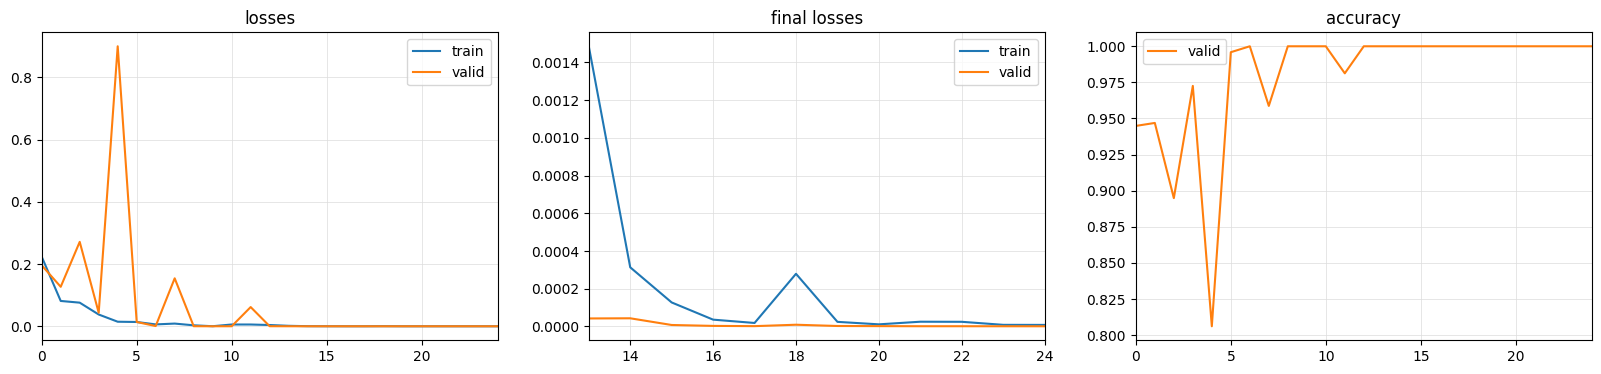

stock_group 1


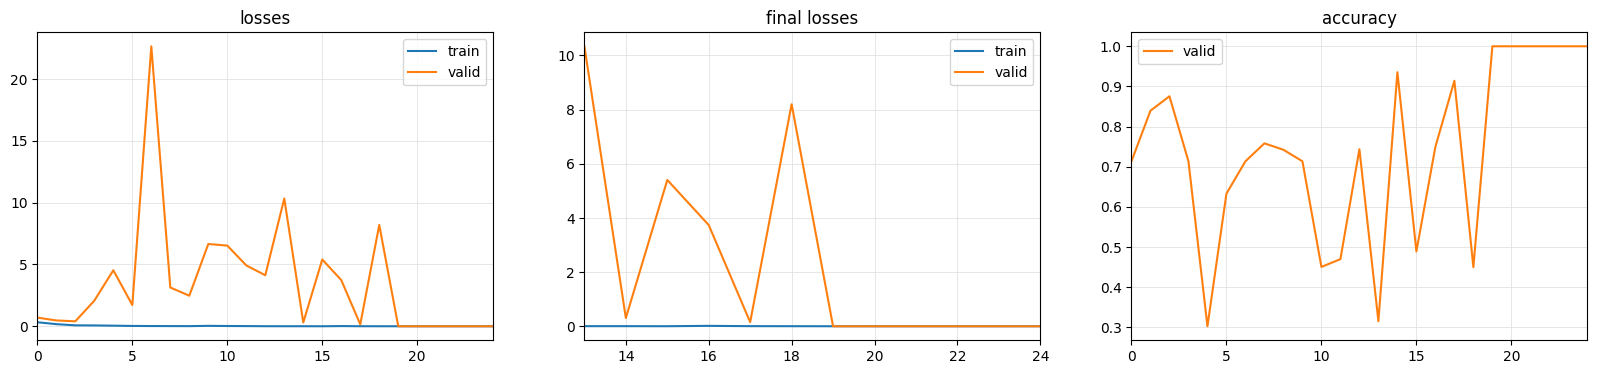

stock_group 2


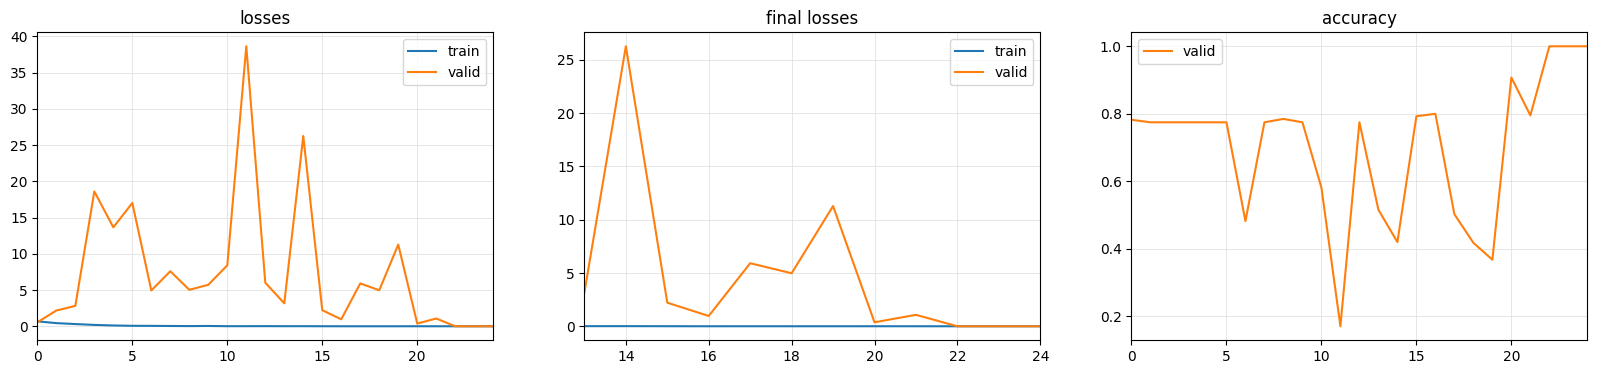

stock_group 3


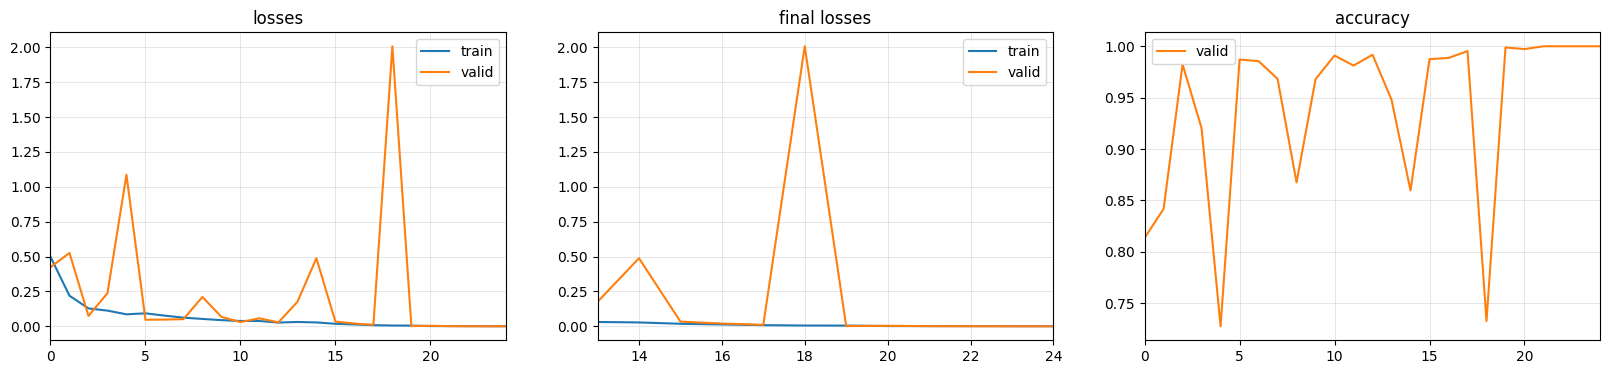

stock_group 4


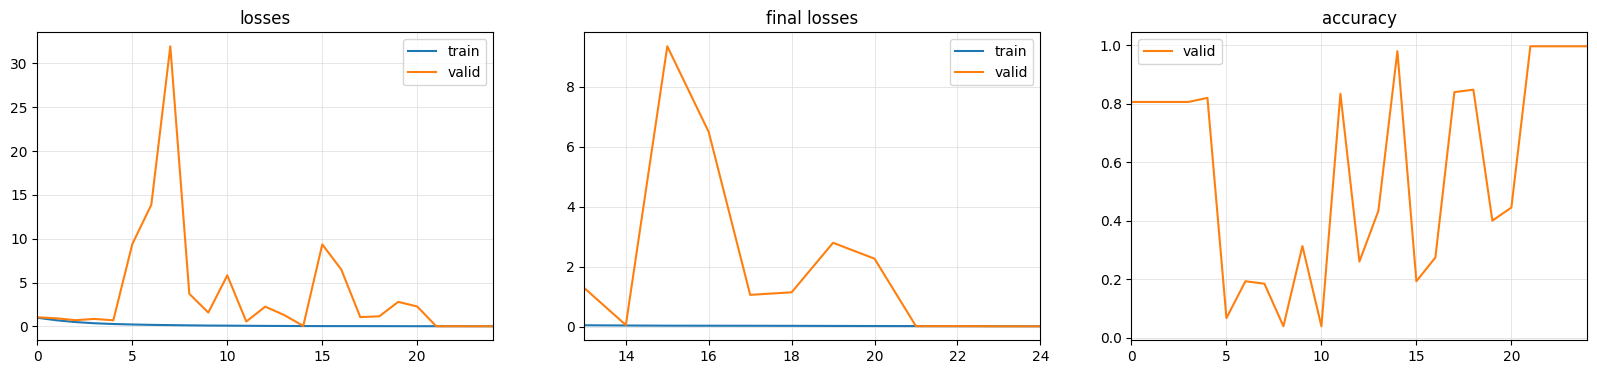

stock_group 5


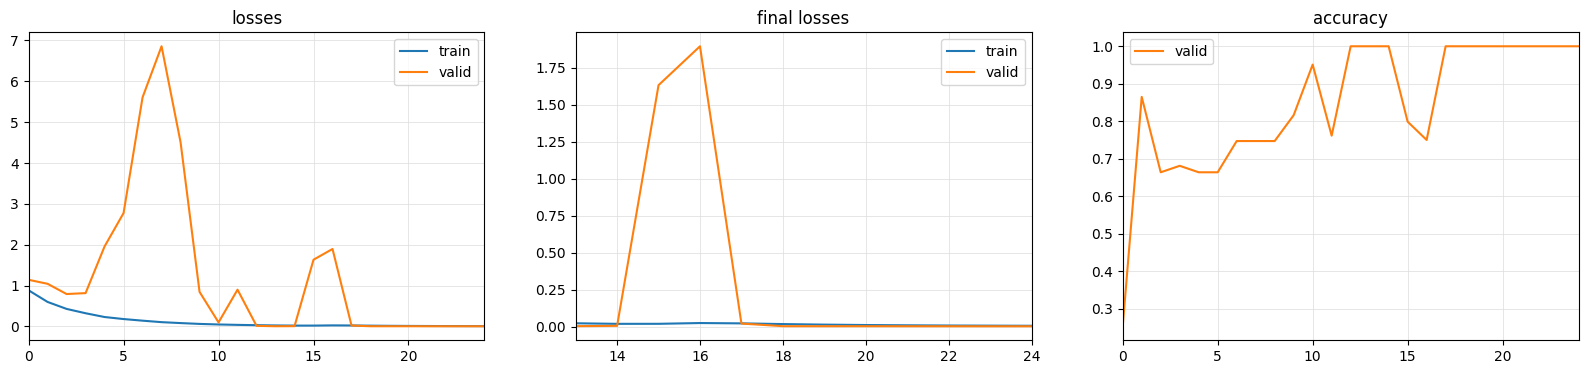

In [74]:
for i in range(stock_group_num):
    print('stock_group',i)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length(data,24)
        label=np.full(len(process_data), j)
        X.extend([p.transpose() for p in process_data])
        y=np.concatenate((y, label), axis=0)
    X=np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    learn.fit_one_cycle(25, lr_max=1e-3)
    learn.plot_metrics()
    learn.save_all(path='export', dls_fname='dls_'+str(i)+'_'+str(j), model_fname='model_'+str(i)+'_'+str(j), learner_fname='learner_'+str(i)+'_'+str(j))
#     display(type(X_train),X_train.shape)

# Key takeaway

InceptionTime can do the job

In [50]:
X, y, splits = get_classification_data('LSST', split_data=False)

In [53]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

NameError: name 'new_y' is not defined

In [47]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        std=data_seg.adj.std()
        std_list.append(std)
    return std_list

In [ ]:
batch_tfms = TSStandardize(by_sample=True)
mv_clf = TSClassifier(X, y, splits=splits, path='models', arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
mv_clf.fit_one_cycle(10, 1e-2)
mv_clf.export("mv_clf.pkl")

## inference

## inference

## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [102]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 10000
parameters['batch_size'] = 128

## Run TimeGAN for synthetic time-series data generation

TimeGAN uses the original data and network parameters to return the generated synthetic data.

In [103]:
# Run TimeGAN
generated_data = timegan(style_data, parameters,1)   
print('Finish Synthetic Data Generation')





Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons


2022-12-23 14:55:46.484966: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-12-23 14:55:46.530145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:18:00.0
2022-12-23 14:55:46.530238: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory
2022-12-23 14:55:46.530283: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared object file: No such file or directory
2022-12-23 14:55:46.530322: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcufft.so.10.0'; dlerror: libcufft.so.10.0: cannot open shared 

Start Embedding Network Training
step: 0/10000, e_loss: 0.2581
step: 1000/10000, e_loss: 0.0386
step: 2000/10000, e_loss: 0.0326
step: 3000/10000, e_loss: 0.0204
step: 4000/10000, e_loss: 0.0163
step: 5000/10000, e_loss: 0.0147
step: 6000/10000, e_loss: 0.0107
step: 7000/10000, e_loss: 0.0117
step: 8000/10000, e_loss: 0.0094
step: 9000/10000, e_loss: 0.0097
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2494
step: 1000/10000, s_loss: 0.031
step: 2000/10000, s_loss: 0.0251
step: 3000/10000, s_loss: 0.0209
step: 4000/10000, s_loss: 0.0183
step: 5000/10000, s_loss: 0.0198
step: 6000/10000, s_loss: 0.0211
step: 7000/10000, s_loss: 0.0198
step: 8000/10000, s_loss: 0.0182
step: 9000/10000, s_loss: 0.0192
Finish Training with Supervised Loss Only

Start Joint Training
step: 0/10000, d_loss: 2.0363, g_loss_u: 0.6974, g_loss_s: 0.0315, g_loss_v: 0.3525, e_loss_t0: 0.0783
step: 1000/10000, d_loss: 1.3313, g_loss_u: 1.2101, g_loss_s: 0.0245, g_

## Evaluate the generated data

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [104]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
    temp_disc = discriminative_score_metrics(style_data, generated_data)
    discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Instructions for updating:
Please use tf.global_variables instead.


2022-12-23 16:01:42.645732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-23 16:01:42.645760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-23 16:02:04.934936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-23 16:02:04.934967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-23 16:02:27.700290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-23 16:02:27.700321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-23 16:02:50.596406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-23 16:02:50.596443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-23 16:03:13.254605: I tensorflow

Discriminative score: 0.2705


## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [105]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(style_data, generated_data)
  predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

2022-12-23 16:03:36.388390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-23 16:03:36.388414: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-23 16:04:40.076602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-23 16:04:40.076636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-23 16:05:43.961779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-23 16:05:43.961810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-23 16:06:47.599776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-23 16:06:47.599813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-23 16:07:49.782367: I tensorflow

Predictive score: 0.0733


## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

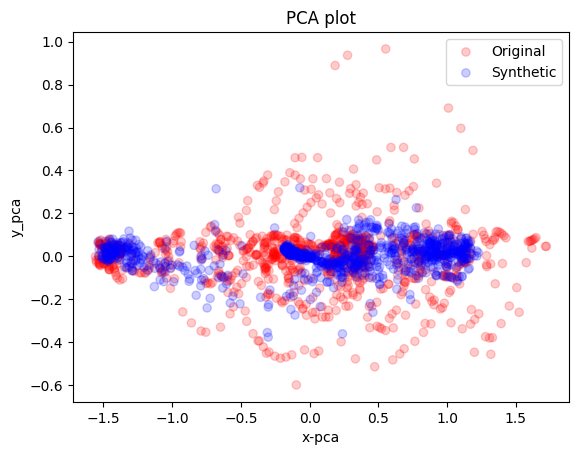

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.038448
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.072037
[t-SNE] KL divergence after 300 iterations: 0.909210


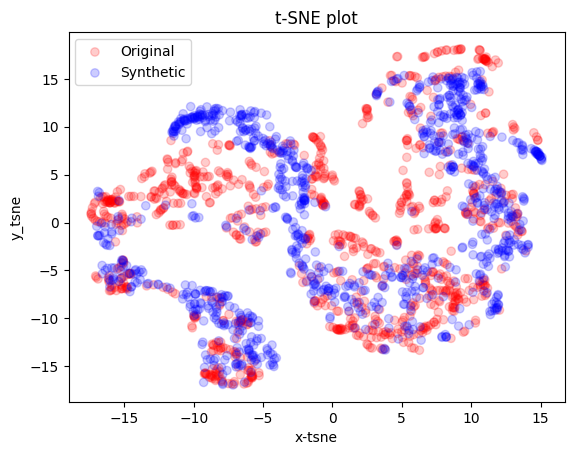

In [106]:
visualization(style_data, generated_data, 'pca')
visualization(style_data, generated_data, 'tsne')